Shape: (7043, 21)
Numeric cols: ['SeniorCitizen', 'tenure', 'MonthlyCharges']
Categorical cols: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService']
Train shape: (5634, 20) Test shape: (1409, 20)
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best estimator: Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  StandardScaler(with_mean=False),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                     

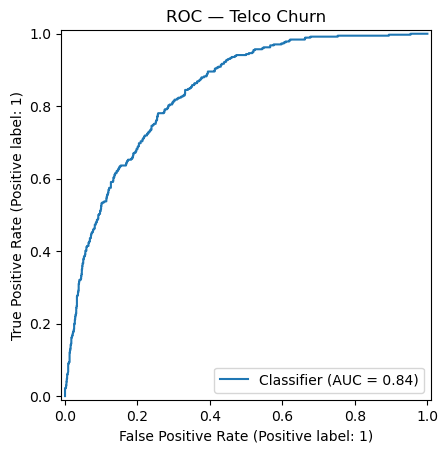

✅ Saved pipeline to: artifacts/telco_churn_pipeline.joblib


In [3]:

import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, roc_auc_score

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


# Load Dataset

csv_path = "Telco-Customer-Churn.csv"

if not os.path.exists(csv_path):
    import urllib.request
    url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
    urllib.request.urlretrieve(url, csv_path)
    print("Downloaded dataset to", csv_path)

df = pd.read_csv(csv_path)
print("Shape:", df.shape)
df.head()


# Clean Dataset

target_col = "Churn"
df[target_col] = df[target_col].astype(str).str.strip().str.lower().map({
    "yes": 1, "no": 0, "true": 1, "false": 0
})

y = df[target_col].astype(int)
X = df.drop(columns=[target_col])

# Identify column types
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric cols:", num_cols[:5])
print("Categorical cols:", cat_cols[:5])


# Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


# Preprocessing + Pipeline

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

pipe = Pipeline(steps=[
    ("pre", pre),
    ("model", LogisticRegression(max_iter=200))
])


# GridSearch (LogReg + RF)

param_grid = [
    {
        "model": [LogisticRegression(max_iter=200)],
        "model__C": [0.1, 1.0, 3.0]
    },
    {
        "model": [RandomForestClassifier(random_state=RANDOM_SEED)],
        "model__n_estimators": [200, 400],
        "model__max_depth": [None, 8, 16]
    }
]

gs = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1, scoring="roc_auc", verbose=1)
gs.fit(X_train, y_train)

print("Best estimator:", gs.best_estimator_)
print("Best params:", gs.best_params_)
print("Best CV AUC:", gs.best_score_)


# Evaluation

best = gs.best_estimator_
proba = best.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)

print("Test ROC-AUC:", roc_auc_score(y_test, proba))
print("\nClassification Report:\n", classification_report(y_test, pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, pred))

RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC — Telco Churn")
plt.show()

# ============================
# Save Pipeline
# ============================
os.makedirs("artifacts", exist_ok=True)
model_path = "artifacts/telco_churn_pipeline.joblib"
joblib.dump(best, model_path)
print("✅ Saved pipeline to:", model_path)
